<a href="https://colab.research.google.com/github/MDankloff/Cluster-Bias-Disco/blob/main/Student_data_exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

In [73]:
students = pd.read_csv('students.csv')
students.info()
#print(students.iloc[3])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

In [74]:
print(students['Target'].unique())
#print(students['Mother\'s occupation'].unique())

['Dropout' 'Graduate' 'Enrolled']


In [75]:
# Convert 'Target' to numerical features for each class
students['Dropout'] = (students['Target'] == 'Dropout').astype(int)
students['Enrolled'] = (students['Target'] == 'Enrolled').astype(int)
students['Graduate'] = (students['Target'] == 'Graduate').astype(int)

# Define features (X) and target variables for each class
x = students.drop(['Target', 'Dropout', 'Enrolled', 'Graduate'], axis=1)
y_dropout = students['Dropout']
y_enrolled = students['Enrolled']
y_graduate = students['Graduate']


In [76]:
print(students.iloc[3])

Marital status                                            1
Application mode                                          8
Application order                                         2
Course                                                   15
Daytime/evening attendance                                1
Previous qualification                                    1
Nacionality                                               1
Mother's qualification                                   23
Father's qualification                                   27
Mother's occupation                                       6
Father's occupation                                       4
Displaced                                                 1
Educational special needs                                 0
Debtor                                                    0
Tuition fees up to date                                   1
Gender                                                    0
Scholarship holder                      

In [77]:
#Train RF model to predict drop out
x_train, x_test, y_train_dropout, y_test_dropout = train_test_split(
    x, y_dropout, test_size=0.2, shuffle=True, stratify=y_dropout
)

model_dropout = RandomForestClassifier()
model_dropout.fit(x_train, y_train_dropout)

yhat_dropout = model_dropout.predict(x_test)
len(yhat_dropout)

885

In [78]:
#Get the errors
predictions = pd.DataFrame()
predictions['predicted_class'] = yhat_dropout.tolist()
predictions = predictions.set_index(x_test.index)
predictions['true_class'] = y_test_dropout
predictions['errors'] = abs(predictions['predicted_class'] - predictions['true_class'])

students = x_test.merge(predictions, how= 'outer', left_index=True, right_index=True)
errors = students['errors']
df_out = students.drop(['predicted_class', 'true_class', 'errors'], axis=1)
students[students['errors']==1]

#accuracy
accuracy = accuracy_score(predictions['true_class'], predictions['predicted_class'])
print(f"Accuracy: {accuracy:.4f}")

#confusion matrix
cm = confusion_matrix(predictions['true_class'], predictions['predicted_class'])
print(cm)

Accuracy: 0.8814
[[574  27]
 [ 78 206]]


In [79]:
#add error labels
def get_error_type(row):
  true_class = row['true_class']
  predicted_class = row['predicted_class']

  if true_class == predicted_class and true_class == 1:
      row['TP'] = 1
      row['TN'] = 0
      row['FN'] = 0
      row['FP'] = 0
  elif true_class == predicted_class and true_class == 0:
      row['TP'] = 0
      row['TN'] = 1
      row['FN'] = 0
      row['FP'] = 0
  elif true_class != predicted_class and true_class == 1:
      row['TP'] = 0
      row['TN'] = 0
      row['FN'] = 1
      row['FP'] = 0
  elif true_class != predicted_class and true_class == 0:
      row['TP'] = 0
      row['TN'] = 0
      row['FN'] = 0
      row['FP'] = 1

  return row

#apply function to rows in data
students_werror = students.apply(get_error_type, axis=1)

print(students_werror)

      Marital status  Application mode  Application order  Course  \
3054             1.0               8.0                1.0    10.0   
1827             1.0               8.0                1.0     6.0   
3944             5.0              12.0                1.0     4.0   
3887             1.0               1.0                1.0    10.0   
741              1.0               1.0                1.0    11.0   
...              ...               ...                ...     ...   
1781             1.0               1.0                5.0     5.0   
3279             4.0              12.0                1.0     3.0   
1877             1.0               1.0                5.0    12.0   
1096             1.0               8.0                1.0    14.0   
3733             2.0              12.0                1.0    10.0   

      Daytime/evening attendance  Previous qualification  Nacionality  \
3054                         1.0                     1.0          1.0   
1827                     

In [82]:
errors_df = students_werror[['TP', 'TN', 'FN', 'FP']]
students_werror['Error_type'] = errors_df.idxmax(axis=1).astype('category')


<ipython-input-84-4507db8b139d>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  errors_by_gender = students_werror.groupby(['Gender','Error_type']).size().unstack(fill_value=0)


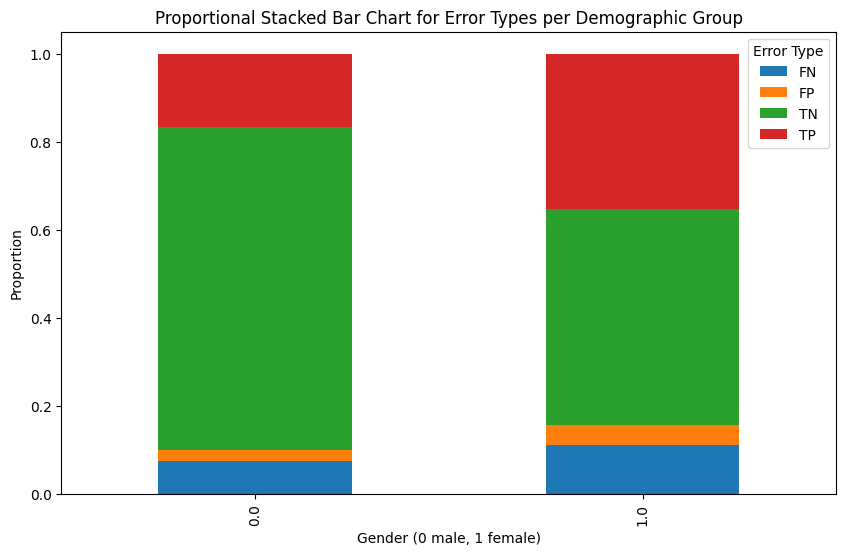

In [84]:
errors_by_gender = students_werror.groupby(['Gender','Error_type']).size().unstack(fill_value=0)
# Normalize counts along the y-axis
error_by_gender_proportions = errors_by_gender.div(errors_by_gender.sum(axis=1), axis=0)

# Plot the proportional stacked bar chart
error_by_gender_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.title('Proportional Stacked Bar Chart for Error Types per Demographic Group')
plt.xlabel('Gender (0 male, 1 female)')
plt.ylabel('Proportion')
plt.legend(title='Error Type', loc='upper right')

# Show the plot
plt.show()